# Cross-Validation 

In [1]:
import os
import sys
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-3.2.1-bin-hadoop3.2"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.9.3-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

In [2]:
# Run this cell if you are using sklearn for the first time
!pip3 install -q sklearn --user
!pip3 install -q matplotlib --user

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Regularization').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/21 18:31:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from sklearn.datasets import load_diabetes
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['y'] = diabetes.target
sdf = spark.createDataFrame(df)

assembler = VectorAssembler(inputCols=[c for c in sdf.columns if c != 'y'],
                            outputCol='features')
dataset = assembler.transform(sdf)
dataset.show(5)

+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-----+--------------------+
|                 age|               sex|                bmi|                  bp|                  s1|                 s2|                 s3|                  s4|                 s5|                 s6|    y|            features|
+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-----+--------------------+
|  0.0380759064334241|0.0506801187398187| 0.0616962065186885|  0.0218723549949558| -0.0442234984244464|-0.0348207628376986|-0.0434008456520269|-0.00259226199818282| 0.0199084208763183|-0.0176461251598052|151.0|[0.03807590643342...|
|-0.00188201652779104|-0.044641636506989|-0.0514740612388061| -0.0263278

## We haven't tested models on unseen data!

In [6]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)


In [7]:
train, test = dataset.randomSplit([0.5, 0.5], 25)
lr = LinearRegression(featuresCol='features', labelCol='y')
model = lr.fit(train)

# Evaluate on training data
summary_train = model.evaluate(train)
print('R2 (training): ', summary_train.r2)

# Evaluate on training data
summary_test = model.evaluate(test)
print('R2 (testing): ', summary_test.r2)

22/06/21 18:31:20 WARN Instrumentation: [54c0e6d6] regParam is zero, which might cause numerical instability and overfitting.
22/06/21 18:31:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/06/21 18:31:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/06/21 18:31:21 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


R2 (training):  0.508949751797882
R2 (testing):  0.5102102762041921


## Increase training fraction?

In [8]:
# We specify this so that the train and test data set always have the same rows, respectively
# np.random.seed(0)

22/06/21 18:31:23 WARN Instrumentation: [b8bc36cb] regParam is zero, which might cause numerical instability and overfitting.
22/06/21 18:31:24 WARN Instrumentation: [8986350a] regParam is zero, which might cause numerical instability and overfitting.
22/06/21 18:31:25 WARN Instrumentation: [aa18453f] regParam is zero, which might cause numerical instability and overfitting.
22/06/21 18:31:27 WARN Instrumentation: [bb8d9005] regParam is zero, which might cause numerical instability and overfitting.


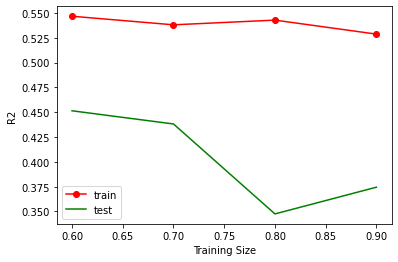

In [9]:
p_train = [0.6, 0.7, 0.8, 0.9]
train_r2 = []
test_r2 = []

for p in p_train:
    train, test = dataset.randomSplit([p, 1 - p], 25)
    model = lr.fit(train)
    
    # Evaluate on training data
    summary_train = model.evaluate(train)
    train_r2.append(summary_train.r2)

    # Evaluate on training data
    summary_test = model.evaluate(test)
    test_r2.append(summary_test.r2)

plt.plot(p_train, train_r2, 'ro-', label='train')
plt.plot(p_train, test_r2, 'g', label='test')
plt.xlabel('Training Size')
plt.ylabel('R2')
plt.legend()